# Weather Dataset Classification 🌤️

In [ ]:
import tensorflow as tf  # Core TensorFlow library
import kagglehub  # Library to download Kaggle assets
from tensorflow.keras.utils import image_dataset_from_directory  # Utility to load images from directory

# Download the specified dataset from Kaggle
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")

# Append the subdirectory name where images are located
path = path + "/dataset"

# Display the final path to the dataset directory
path

'/kaggle/input/weather-dataset/dataset'

In [ ]:
train_ds, val_test_ds = image_dataset_from_directory(
    directory=path,          # Path to images
    batch_size=32,           # Batch size
    image_size=(256, 256),   # Resize images
    validation_split=0.3,    # Split data (0.3 for validation/test)
    subset='both',           # Return both splits
    seed=123,                 # Seed for reproducible split
)

Found 6862 files belonging to 11 classes.
Using 4804 files for training.
Using 2058 files for validation.


In [ ]:
# Get class names inferred from directories
class_names = train_ds.class_names
# Get the number of classes
num_classes = len(class_names)
# Get the number of batches in the training set
train_batch = tf.data.experimental.cardinality(train_ds).numpy()
# Determine validation size (half of val_test_ds batches)
val_size = int(tf.data.experimental.cardinality(val_test_ds).numpy() * 0.5)
# Create validation dataset by taking batches
valid_ds = val_test_ds.take(val_size)
# Create test dataset by skipping batches
test_ds = val_test_ds.skip(val_size)
# Print the class names
print("Class names:", class_names)

Class names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [ ]:
# Prepare training dataset: cache, shuffle, prefetch for performance
train = train_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
# Prepare validation dataset: cache, prefetch for performance (no shuffle)
valid = valid_ds.cache().prefetch(tf.data.AUTOTUNE)
# Prepare test dataset: cache, prefetch for performance (no shuffle)
test = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
## true labels for testset.
y_true = []
for images, labels in test:
    y_true.extend(labels.numpy())

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import regularizers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input),
    tf.keras.applications.efficientnet.EfficientNetB7(weights='imagenet', include_top=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(514, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')])

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# Freeze the first 500 layers of the EfficientNetB7 base model
for i, layer in enumerate(model.layers[5].layers):
  if i < 500:
    layer.trainable = False

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train, epochs=50, validation_data=valid, callbacks=[early_stopping])

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.4926 - loss: 7.2479 - val_accuracy: 0.7832 - val_loss: 4.1281
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 145s 962ms/step - accuracy: 0.7045 - loss: 4.1161 - val_accuracy: 0.6533 - val_loss: 73.4645
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 145s 964ms/step - accuracy: 0.6941 - loss: 3.7174 - val_accuracy: 0.8125 - val_loss: 3.4315
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 145s 964ms/step - accuracy: 0.7348 - loss: 3.1892 - val_accuracy: 0.8037 - val_loss: 2.6009
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 145s 959ms/step - accuracy: 0.7303 - loss: 2.8713 - val_accuracy: 0.7588 - val_loss: 11.9890
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 145s 959ms/step - accuracy: 0.7513 - loss: 2.7057 - val_accuracy: 0.8057 - val_loss: 3.3839
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 145s 959ms/step - accuracy: 0.7414 - loss: 2.7611 - val_accuracy: 0.7227 - val_loss: 40.0245
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 145s 959ms/step - accuracy: 0.7329 -

In [ ]:
train_loss,train_acc = model.evaluate(train)
val_loss,val_acc = model.evaluate(valid)
test_loss,test_acc = model.evaluate(test)

print(f'Training Acurracy: {train_acc}')
print(f'Validation Acurracy: {val_acc}')
print(f'Test Acurracy: {test_acc}')

151/151 ━━━━━━━━━━━━━━━━━━━━ 81s 535ms/step - accuracy: 0.9629 - loss: 0.5510
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 534ms/step - accuracy: 0.8984 - loss: 0.8103
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 549ms/step - accuracy: 0.9136 - loss: 0.7796
Training Acurracy: 0.9608659744262695
Validation Acurracy: 0.8994140625
Test Acurracy: 0.9139264822006226


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model.predict(test), axis=1)
accuracy_sklearn = accuracy_score(y_true, y_pred)
print(f"Accuracy using scikit-learn: {accuracy_sklearn:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 765ms/step
Accuracy using scikit-learn: 0.9139


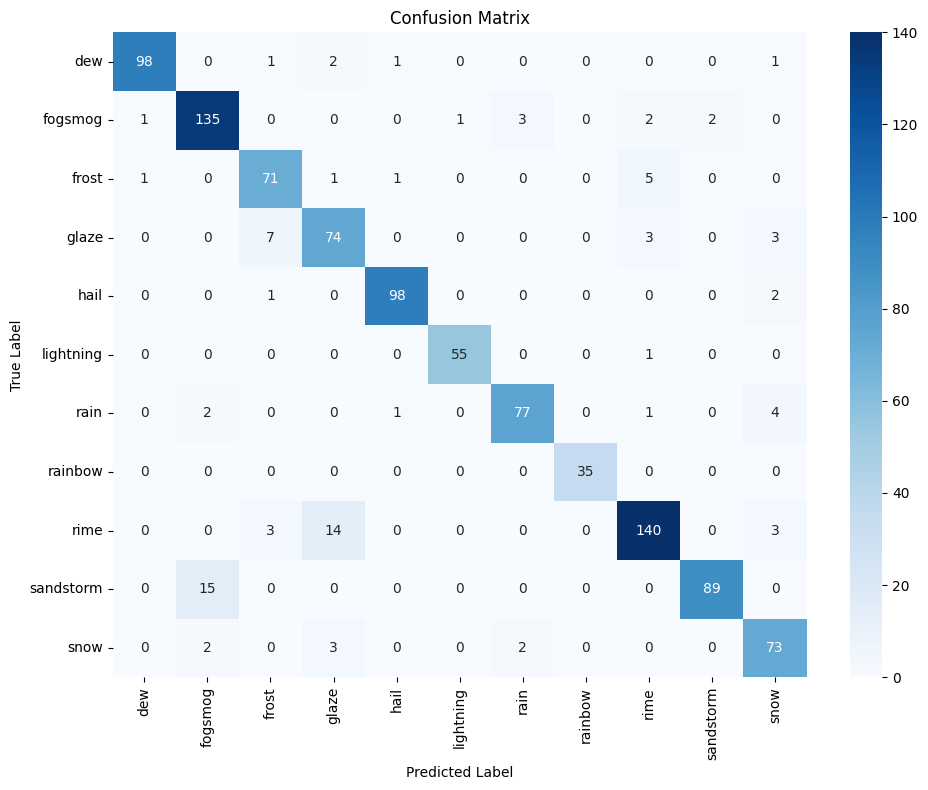

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns




# Compute the confusion matrix

unique_labels = np.unique(np.concatenate((y_true, y_pred)))
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using Seaborn with a fixed figure size
plt.figure(figsize=(10, 8)) # Fixed figure size

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 521ms/step


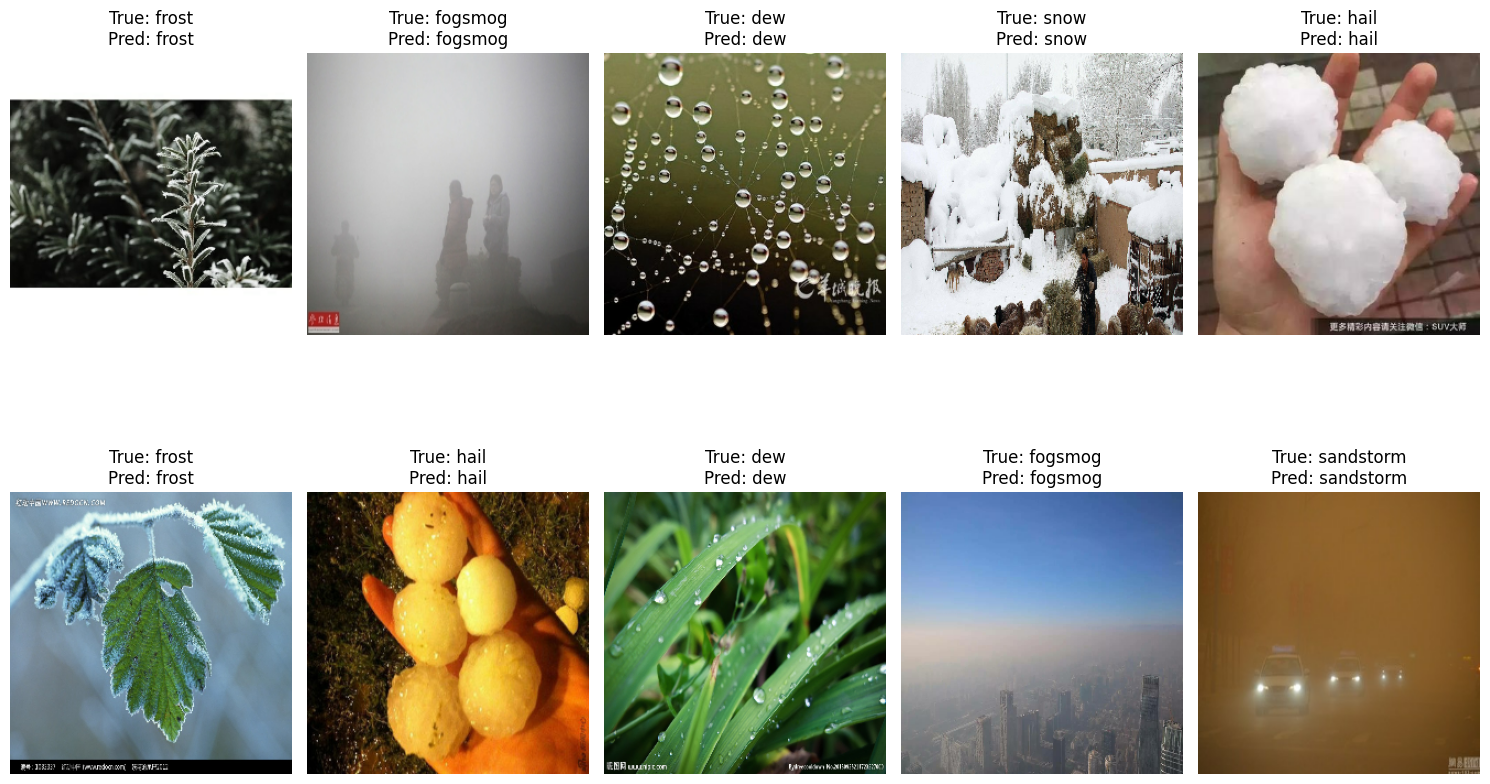

In [ ]:
# Get a batch of images and labels from the test dataset
for images, labels in test.take(1):
    # Make predictions on the batch
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot the images and their labels
    plt.figure(figsize=(12, 6)) # Adjusted figure size for two rows of five
    for i in range(10): # Display the first 10 images in the batch
        ax = plt.subplot(2, 5, i + 1) # Changed to 2 rows and 5 columns
        plt.imshow(images[i].numpy().astype("uint8"))
        # Get the true and predicted class names
        true_label = class_names[labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()